$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bm}[1]{{\bf #1}}
\newcommand{\bb}[1]{\bm{\mathrm{#1}}}
$$

# Part 2: Variational Autoencoder
<a id=part2></a>

In this part we will learn to generate new data using a special type of autoencoder model which allows us to 
sample from its latent space. We'll implement and train a VAE and use it to generate new images.

In [7]:
import unittest
import os
import sys
import pathlib
import urllib
import shutil
import re
import zipfile

import numpy as np
import torch
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
test = unittest.TestCase()
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


### Obtaining the dataset
<a id=part2_1></a>

Let's begin by downloading a dataset of images that we want to learn to generate. 
We'll use the [Labeled Faces in the Wild](http://vis-www.cs.umass.edu/lfw/) (LFW) dataset which contains many labeled faces of famous individuals.

We're going to train our generative model to generate a specific face, not just any face.
Since the person with the most images in this dataset is former president George W. Bush, we'll set out to train a Bush Generator :)

However, if you feel adventurous and/or prefer to generate something else, feel free to edit the `PART2_CUSTOM_DATA_URL` variable in `hw3/answers.py`.

In [9]:
import cs236781.plot as plot
import cs236781.download
from hw3.answers import PART2_CUSTOM_DATA_URL as CUSTOM_DATA_URL

DATA_DIR = pathlib.Path.home().joinpath('.pytorch-datasets')
if CUSTOM_DATA_URL is None:
    DATA_URL = 'http://vis-www.cs.umass.edu/lfw/lfw-bush.zip'
else:
    DATA_URL = CUSTOM_DATA_URL

_, dataset_dir = cs236781.download.download_data(out_path=DATA_DIR, url=DATA_URL, extract=True, force=False)

File /home/ilay.kamai/.pytorch-datasets/lfw-bush.zip exists, skipping download.
Extracting /home/ilay.kamai/.pytorch-datasets/lfw-bush.zip...
Extracted 531 to /home/ilay.kamai/.pytorch-datasets/lfw/George_W_Bush


Create a `Dataset` object that will load the extraced images:

In [10]:
import torchvision.transforms as T
from torchvision.datasets import ImageFolder

im_size = 64
tf = T.Compose([
    # Resize to constant spatial dimensions
    T.Resize((im_size, im_size)),
    # PIL.Image -> torch.Tensor
    T.ToTensor(),
    # Dynamic range [0,1] -> [-1, 1]
    T.Normalize(mean=(.5,.5,.5), std=(.5,.5,.5)),
])

ds_gwb = ImageFolder(os.path.dirname(dataset_dir), tf)

OK, let's see what we got. You can run the following block multiple times to display a random subset of images from the dataset.

Found 530 images in dataset folder.


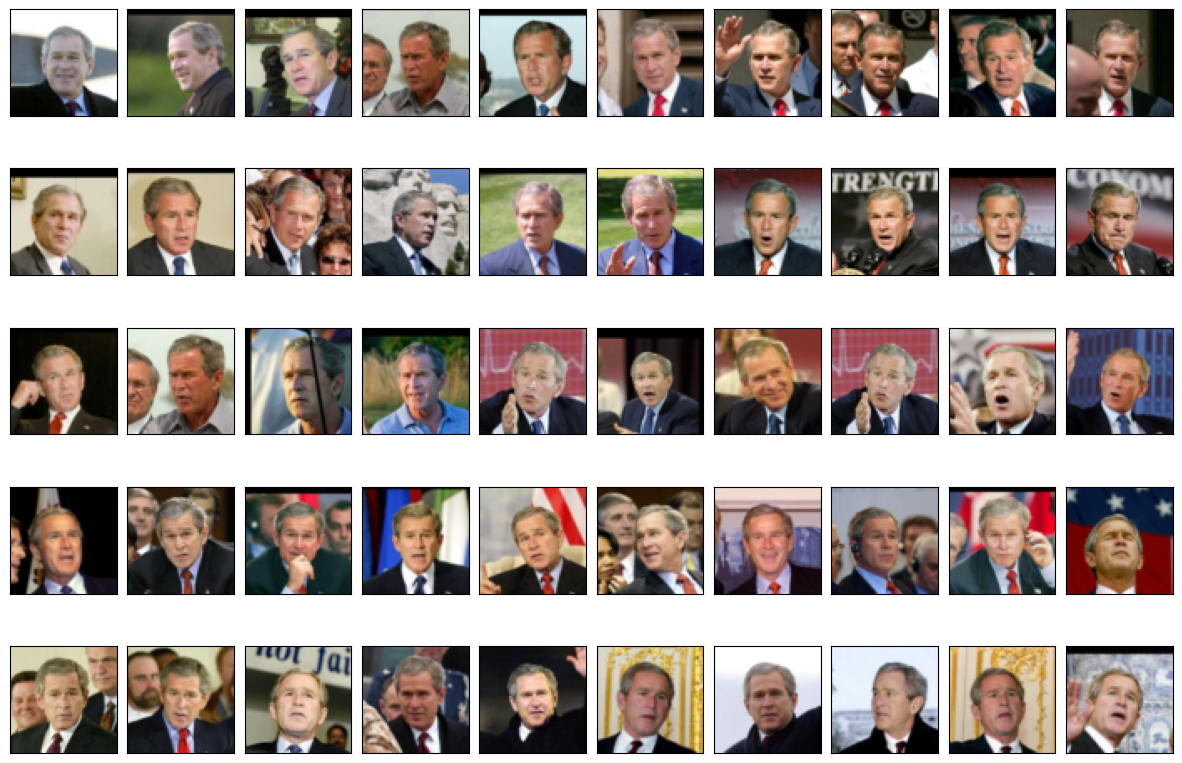

In [11]:
_ = plot.dataset_first_n(ds_gwb, 50, figsize=(15,10), nrows=5)
print(f'Found {len(ds_gwb)} images in dataset folder.')

In [12]:
x0, y0 = ds_gwb[0]
x0 = x0.unsqueeze(0).to(device)
print(x0.shape)

test.assertSequenceEqual(x0.shape, (1, 3, im_size, im_size))

torch.Size([1, 3, 64, 64])


## The Variational Autoencoder
<a id=part2_2></a>

An autoencoder is a model which learns a representation of data in an **unsupervised** fashion (i.e without any labels).
Recall it's general form from the lecture:

<img src="imgs/autoencoder.jpg"/>

An autoencoder maps an instance $\bb{x}$ to a **latent-space** representation $\bb{z}$.
It has an encoder part, $\Phi_{\bb{\alpha}}(\bb{x})$ (a model with parameters $\bb{\alpha}$)
and a decoder part, $\Psi_{\bb{\beta}}(\bb{z})$ (a model with parameters $\bb{\beta}$).

While autoencoders can learn useful representations,
generally it's hard to use them as generative models because there's no distribution we can sample from in the latent space. In other words, we have no way to choose a point $\bb{z}$ in the latent space
such that $\Psi(\bb{z})$ will end up on the data manifold in the instance space.

<img src="imgs/ae_sampling.jpg"/>


The variational autoencoder (VAE), first proposed by [Kingma and Welling](https://arxiv.org/pdf/1312.6114.pdf), addresses this issue by taking a probabilistic perspective. 
Briefly, a VAE model can be described as follows.

We define, in Baysean terminology,
- The **prior** distribution $p(\bb{Z})$ on points in the latent space.
- The **posterior** distribution of points in the latent spaces given a specific instance: $p(\bb{Z}|\bb{X})$.
- The **likelihood** distribution of a sample $\bb{X}$ given a latent-space representation: $p(\bb{X}|\bb{Z})$.
- The **evidence** distribution $p(\bb{X})$ which is the distribution of the instance space due to the generative process.

To create our variational **decoder** we'll further specify:

- A parametric likelihood distribution, $p _{\bb{\beta}}(\bb{X} | \bb{Z}=\bb{z}) = \mathcal{N}( \Psi _{\bb{\beta}}(\bb{z}) , \sigma^2 \bb{I} )$. The interpretation is that given a latent $\bb{z}$, we map it to a point normally distributed around the point calculated by our decoder neural network. Note that here $\sigma^2$ is a hyperparameter while $\vec{\beta}$ represents the network parameters.
- A fixed latent-space prior distribution of $p(\bb{Z}) = \mathcal{N}(\bb{0},\bb{I})$.

This setting allows us to generate a new instance $\bb{x}$ by sampling $\bb{z}$ from the multivariate normal
distribution, obtaining the instance-space mean $\Psi _{\bb{\beta}}(\bb{z})$ using our decoder network,
and then sampling $\bb{x}$ from $\mathcal{N}( \Psi _{\bb{\beta}}(\bb{z}) , \sigma^2 \bb{I} )$.

Our variational **encoder** will approximate the posterior with a parametric distribution 
$q _{\bb{\alpha}}(\bb{Z} | \bb{x}) =
\mathcal{N}( \bb{\mu} _{\bb{\alpha}}(\bb{x}),  \mathrm{diag}\{ \bb{\sigma}^2_{\bb{\alpha}}(\bb{x}) \} )$.
The interpretation is that our encoder model, $\Phi_{\vec{\alpha}}(\bb{x})$, calculates
the mean and variance of the posterior distribution, and samples $\bb{z}$ based on them.
An important nuance here is that our network can't contain any stochastic elements that
depend on the model parameters, otherwise we won't be able to back-propagate to those parameters.
So sampling $\bb{z}$ from $\mathcal{N}( \bb{\mu} _{\bb{\alpha}}(\bb{x}),  \mathrm{diag}\{ \bb{\sigma}^2_{\bb{\alpha}}(\bb{x}) \} )$ is not an option.
The solution is to use what's known as the **reparametrization trick**: sample from an isotropic Gaussian, 
i.e. $\bb{u}\sim\mathcal{N}(\bb{0},\bb{I})$ (which doesn't depend on trainable parameters), and calculate the latent representation as
$\bb{z} = \bb{\mu} _{\bb{\alpha}}(\bb{x}) + \bb{u}\odot\bb{\sigma}_{\bb{\alpha}}(\bb{x})$.

To train a VAE model, we maximize the evidence distribution, $p(\bb{X})$ (see question below). 
The **VAE loss** can therefore be stated as minimizing $\mathcal{L} = -\mathbb{E}_{\bb{x}} \log p(\bb{X})$.
Although this expectation is intractable,
we can obtain a lower-bound for $p(\bb{X})$ (the evidence lower bound, "ELBO", shown in the lecture):

$$
\log p(\bb{X}) \ge \mathbb{E} _{\bb{z} \sim q _{\bb{\alpha}} }\left[ \log  p _{\bb{\beta}}(\bb{X} | \bb{z}) \right]
-  \mathcal{D} _{\mathrm{KL}}\left(q _{\bb{\alpha}}(\bb{Z} | \bb{X})\,\left\|\, p(\bb{Z} )\right.\right)
$$

where
$
\mathcal{D} _{\mathrm{KL}}(q\left\|\right.p) =
\mathbb{E}_{\bb{z}\sim q}\left[ \log \frac{q(\bb{Z})}{p(\bb{Z})} \right]
$
is the Kullback-Liebler divergence, which can be interpreted as the information gained by using the posterior $q(\bb{Z|X})$ instead of the prior distribution $p(\bb{Z})$.

Using the ELBO, the VAE loss becomes,
$$
\mathcal{L}(\vec{\alpha},\vec{\beta}) = \mathbb{E} _{\bb{x}}  \left[ 
\mathbb{E} _{\bb{z} \sim q _{\bb{\alpha}} }\left[ -\log  p _{\bb{\beta}}(\bb{x} | \bb{z}) \right]
+  \mathcal{D} _{\mathrm{KL}}\left(q _{\bb{\alpha}}(\bb{Z} | \bb{x})\,\left\|\, p(\bb{Z} )\right.\right)
\right].
$$

By remembering that the likelihood is a Gaussian distribution with a diagonal covariance and by applying the reparametrization trick, we can write the above as

$$
\mathcal{L}(\vec{\alpha},\vec{\beta}) = \mathbb{E} _{\bb{x}}  \left[ 
\mathbb{E} _{\bb{z} \sim q _{\bb{\alpha}} }
\left[ 
\frac{1}{2\sigma^2}\left\| \bb{x}- \Psi _{\bb{\beta}}\left(  \bb{\mu} _{\bb{\alpha}}(\bb{x})  + \bb{\Sigma}^{\frac{1}{2}} _{\bb{\alpha}}(\bb{x}) \bb{u}   \right) \right\| _2^2
\right]
+  \mathcal{D} _{\mathrm{KL}}\left(q _{\bb{\alpha}}(\bb{Z} | \bb{x})\,\left\|\, p(\bb{Z} )\right.\right)
\right].
$$



### Model Implementation
<a id=part2_3></a>

Obviously our model will have two parts, an encoder and a decoder.
Since we're working with images, we'll implement both as deep **convolutional** networks, where the decoder is a "mirror image" of the encoder implemented with adjoint (AKA transposed) convolutions.
Between the encoder CNN and the decoder CNN we'll implement the sampling from
the parametric posterior approximator $q_{\bb{\alpha}}(\bb{Z}|\bb{x})$
to make it a VAE model and not just a regular autoencoder (of course, this is not yet enough to create a VAE,
since we also need a special loss function which we'll get to later).

First let's implement just the CNN part of the Encoder network
(this is not the full $\Phi_{\vec{\alpha}}(\bb{x})$ yet).
As usual, it should take an input image and map to a activation volume of a specified depth.
We'll consider this volume as the features we extract from the input image.
Later we'll use these to create the latent space representation of the input.

In [13]:
import hw3.autoencoder as autoencoder

in_channels = 3
out_channels = 1024
encoder_cnn = autoencoder.EncoderCNN(in_channels, out_channels).to(device)
print(encoder_cnn)

h = encoder_cnn(x0)
print(h.shape)

test.assertEqual(h.dim(), 4)
test.assertSequenceEqual(h.shape[0:2], (1, out_channels))

EncoderCNN(
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout2d(p=0.25, inplace=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout2d(p=0.25, inplace=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout2d(p=0.25, inplace=False)
    (12): Conv2d(256, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (13): ReLU()
    (14): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): Dropout2d(p=0.25, inplace=False)
  )
)
torch.Size([1, 1024, 4, 4])


Now let's implement the CNN part of the Decoder.
Again this is not yet the full $\Psi _{\bb{\beta}}(\bb{z})$. It should take an activation volume produced
by your `EncoderCNN` and output an image of the same dimensions as the Encoder's input was.
This can be a CNN which is like a "mirror image" of the the Encoder. For example, replace convolutions with transposed convolutions, downsampling with up-sampling etc.
Consult the documentation of [ConvTranspose2D](https://pytorch.org/docs/0.4.1/nn.html#convtranspose2d)
to figure out how to reverse your convolutional layers in terms of input and output dimensions. Note that the decoder doesn't have to be exactly the opposite of the encoder and you can experiment with using a different architecture.

**TODO**: Implement the `DecoderCNN` class in the `hw3/autoencoder.py` module.

DecoderCNN(
  (cnn): Sequential(
    (0): ConvTranspose2d(1024, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): Tanh()
  )
)
torch.Size([1, 3, 64, 64])


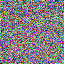

In [14]:
decoder_cnn = autoencoder.DecoderCNN(in_channels=out_channels, out_channels=in_channels).to(device)
print(decoder_cnn)
x0r = decoder_cnn(h)
print(x0r.shape)

test.assertEqual(x0.shape, x0r.shape)

# Should look like colored noise
T.functional.to_pil_image(x0r[0].cpu().detach())

Let's now implement the full VAE Encoder, $\Phi_{\vec{\alpha}}(\vec{x})$.
It will work as follows:
1. Produce a feature vector $\vec{h}$ from the input image $\vec{x}$.
2. Use two affine transforms to convert the features into the mean and log-variance of the posterior, i.e.
    $$
    \begin{align}
        \bb{\mu} _{\bb{\alpha}}(\bb{x}) &= \vec{h}\mattr{W}_{\mathrm{h\mu}} + \vec{b}_{\mathrm{h\mu}} \\
        \log\left(\bb{\sigma}^2_{\bb{\alpha}}(\bb{x})\right) &= \vec{h}\mattr{W}_{\mathrm{h\sigma^2}} + \vec{b}_{\mathrm{h\sigma^2}}
    \end{align}
    $$
3. Use the **reparametrization trick** to create the latent representation $\vec{z}$.

Notice that we model the **log** of the variance, not the actual variance.
The above formulation is proposed in appendix C of the [VAE paper](https://arxiv.org/pdf/1312.6114.pdf).

**TODO**: Implement the `encode()` method in the `VAE` class within the `hw3/autoencoder.py` module.
You'll also need to define your parameters in `__init__()`.

In [15]:
z_dim = 2
vae = autoencoder.VAE(encoder_cnn, decoder_cnn, x0[0].size(), z_dim).to(device)
print(vae)

z, mu, log_sigma2 = vae.encode(x0)

test.assertSequenceEqual(z.shape, (1, z_dim))
test.assertTrue(z.shape == mu.shape == log_sigma2.shape)

print(f'mu(x0)={list(*mu.detach().cpu().numpy())}, sigma2(x0)={list(*torch.exp(log_sigma2).detach().cpu().numpy())}')

VAE(
  (features_encoder): EncoderCNN(
    (cnn): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Dropout2d(p=0.25, inplace=False)
      (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): ReLU()
      (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): Dropout2d(p=0.25, inplace=False)
      (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (9): ReLU()
      (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): Dropout2d(p=0.25, inplace=False)
      (12): Conv2d(256, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (13): ReLU()
      (14): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (15): Dropout2d(p=0.25, inplace=False)
   

Let's sample some 2d latent representations for an input image `x0` and visualize them.

sampled mu tensor([-0.0226,  0.2229])
sampled sigma2 tensor([1.2892, 1.1379])


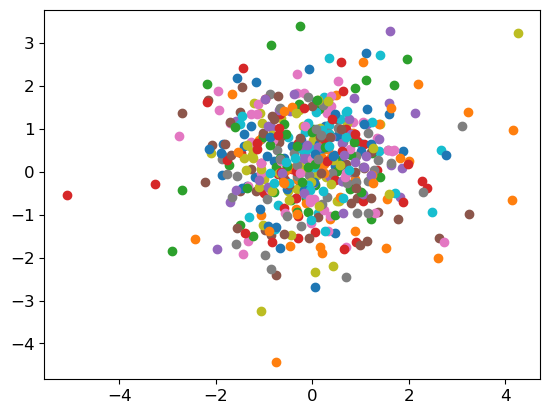

In [16]:
# Sample from q(Z|x)
N = 500
Z = torch.zeros(N, z_dim)
_, ax = plt.subplots()
with torch.no_grad():
    for i in range(N):
        Z[i], _, _ = vae.encode(x0)
        ax.scatter(*Z[i].cpu().numpy())

# Should be close to the mu/sigma in the previous block above
print('sampled mu', torch.mean(Z, dim=0))
print('sampled sigma2', torch.var(Z, dim=0))

Let's now implement the full VAE Decoder, $\Psi _{\bb{\beta}}(\bb{z})$.
It will work as follows:
1. Produce a feature vector $\tilde{\vec{h}}$ from the latent vector $\vec{z}$ using an affine transform.
2. Reconstruct an image $\tilde{\vec{x}}$ from $\tilde{\vec{h}}$ using the decoder CNN.

**TODO**: Implement the `decode()` method in the `VAE` class within the `hw3/autoencoder.py` module.
You'll also need to define your parameters in `__init__()`. You may need to also re-run the block above after you implement this.

In [17]:
x0r = vae.decode(z)

test.assertSequenceEqual(x0r.shape, x0.shape)

Our model's `forward()` function will simply return `decode(encode(x))` as well as the calculated mean and log-variance of the posterior.

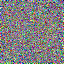

In [18]:
x0r, mu, log_sigma2 = vae(x0)

test.assertSequenceEqual(x0r.shape, x0.shape)
test.assertSequenceEqual(mu.shape, (1, z_dim))
test.assertSequenceEqual(log_sigma2.shape, (1, z_dim))
T.functional.to_pil_image(x0r[0].detach().cpu())

### Loss Implementation
<a id=part2_4></a>

In practice, since we're using SGD, we'll drop the expectation over $\bb{X}$ and instead sample an instance from the training set and compute a point-wise loss. Similarly, we'll drop the expectation over $\bb{Z}$ by sampling from $q_{\vec{\alpha}}(\bb{Z}|\bb{x})$.
Additionally, because the KL divergence is between two Gaussian distributions, there is a closed-form expression for it. These points bring us to the following point-wise loss:

$$
\ell(\vec{\alpha},\vec{\beta};\bb{x}) =
\frac{1}{\sigma^2 d_x} \left\| \bb{x}- \Psi _{\bb{\beta}}\left(  \bb{\mu} _{\bb{\alpha}}(\bb{x})  +
\bb{\Sigma}^{\frac{1}{2}} _{\bb{\alpha}}(\bb{x}) \bb{u}   \right) \right\| _2^2 +
\mathrm{tr}\,\bb{\Sigma} _{\bb{\alpha}}(\bb{x}) +  \|\bb{\mu} _{\bb{\alpha}}(\bb{x})\|^2 _2 - d_z - \log\det \bb{\Sigma} _{\bb{\alpha}}(\bb{x}),
$$

where $d_z$ is the dimension of the latent space, $d_x$ is the dimension of the input and $\bb{u}\sim\mathcal{N}(\bb{0},\bb{I})$.
This pointwise loss is the quantity that we'll compute and minimize with gradient descent.
The first term corresponds to the data-reconstruction loss, while the second term corresponds to the KL-divergence loss.
Note that the scaling by $d_x$ is not derived from the original loss formula and was added directly to the pointwise loss just to normalize the data term.

**TODO**: Implement the `vae_loss()` function in the `hw3/autoencoder.py` module.

In [19]:
from hw3.autoencoder import vae_loss
torch.manual_seed(42)

def test_vae_loss():
    # Test data
    N, C, H, W = 10, 3, 64, 64 
    z_dim = 32
    x  = torch.randn(N, C, H, W)*2 - 1
    xr = torch.randn(N, C, H, W)*2 - 1
    z_mu = torch.randn(N, z_dim)
    z_log_sigma2 = torch.randn(N, z_dim)
    x_sigma2 = 0.9
    
    loss, _, _ = vae_loss(x, xr, z_mu, z_log_sigma2, x_sigma2)
    
    test.assertAlmostEqual(loss.item(), 58.3234367, delta=1e-3)
    return loss

test_vae_loss()

tensor(58.3234)

### Sampling
<a id=part2_5></a>

The main advantage of a VAE is that it can by used as a generative model by sampling the latent space, since
we optimize for a isotropic Gaussian prior $p(\bb{Z})$ in the loss function. Let's now implement this so that we can visualize how our model is doing when we train.

**TODO**: Implement the `sample()` method in the `VAE` class within the `hw3/autoencoder.py` module.

5


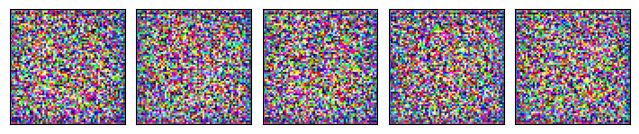

In [20]:
samples = vae.sample(5)
print(len(samples))
_ = plot.tensors_as_images(samples)

### Training
<a id=part2_6></a>

Time to train!

**TODO**:
1. Implement the `VAETrainer` class in the `hw3/training.py` module. Make sure to implement the `checkpoints` feature of the `Trainer` class if you haven't done so already in Part 1.
2. Tweak the hyperparameters in the `part2_vae_hyperparams()` function within the `hw3/answers.py` module.

In [21]:
import torch.optim as optim
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torch.nn import DataParallel
from hw3.training import VAETrainer
from hw3.answers import part2_vae_hyperparams

torch.manual_seed(42)

# Hyperparams
hp = part2_vae_hyperparams()
batch_size = hp['batch_size']
h_dim = hp['h_dim']
z_dim = hp['z_dim']
x_sigma2 = hp['x_sigma2']
learn_rate = hp['learn_rate']
betas = hp['betas']

# Data
split_lengths = [int(len(ds_gwb)*0.9), int(len(ds_gwb)*0.1)]
ds_train, ds_test = random_split(ds_gwb, split_lengths)
dl_train = DataLoader(ds_train, batch_size, shuffle=True)
dl_test  = DataLoader(ds_test,  batch_size, shuffle=True)
im_size = ds_train[0][0].shape

# Model
encoder = autoencoder.EncoderCNN(in_channels=im_size[0], out_channels=h_dim)
decoder = autoencoder.DecoderCNN(in_channels=h_dim, out_channels=im_size[0])
vae = autoencoder.VAE(encoder, decoder, im_size, z_dim)
vae_dp = DataParallel(vae).to(device)

# Optimizer
optimizer = optim.Adam(vae.parameters(), lr=learn_rate, betas=betas)

# Loss
def loss_fn(x, xr, z_mu, z_log_sigma2):
    return autoencoder.vae_loss(x, xr, z_mu, z_log_sigma2, x_sigma2)

# Trainer
trainer = VAETrainer(vae_dp, loss_fn, optimizer, device)
checkpoint_file = 'checkpoints/optim'
checkpoint_file_final = f'{checkpoint_file}_final'
if os.path.isfile(f'{checkpoint_file}.pt'):
    os.remove(f'{checkpoint_file}.pt')

# Show model and hypers
print(vae)
print(hp)

VAE(
  (features_encoder): EncoderCNN(
    (cnn): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Dropout2d(p=0.25, inplace=False)
      (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): ReLU()
      (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): Dropout2d(p=0.25, inplace=False)
      (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (9): ReLU()
      (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): Dropout2d(p=0.25, inplace=False)
      (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (13): ReLU()
      (14): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (15): Dropout2d(p=0.25, inplace=False)
    )

**TODO**:
1. Run the following block to train. It will sample some images from your model every few epochs so you can see the progress.
2. When you're satisfied with your results, rename the checkpoints file by adding `_final`. When you run the `main.py` script to generate your submission, the final checkpoints file will be loaded instead of running training. Note that your final submission zip will not include the `checkpoints/` folder. This is OK.

The images you get should be colorful, with different backgrounds and poses.

In [22]:
import optuna 
def objective(trial):
    h_dim=trial.suggest_int("h_dim",512,1024,512)
    z_dim=trial.suggest_int("z_dim",2,64,4)
    x_sigma2=trial.suggest_float("x_sigma2trial", 0.1,10)
    learn_rate=trial.suggest_float("lr", 1e-5, 1e-2)
    beta1 = trial.suggest_float("beta1", 0.7, 1)
    beta2 = trial.suggest_float("beta2", 0.7, 1)
    betas=(beta1, beta2)
    # Model
    encoder = autoencoder.EncoderCNN(in_channels=im_size[0], out_channels=h_dim)
    decoder = autoencoder.DecoderCNN(in_channels=h_dim, out_channels=im_size[0])
    vae = autoencoder.VAE(encoder, decoder, im_size, z_dim)
    vae_dp = DataParallel(vae).to(device)
    
    # Optimizer
    optimizer = optim.Adam(vae.parameters(), lr=learn_rate, betas=betas)
    
    # Loss
    def loss_fn(x, xr, z_mu, z_log_sigma2):
        return autoencoder.vae_loss(x, xr, z_mu, z_log_sigma2, x_sigma2)
    
    # Trainer
    trainer = VAETrainer(vae_dp, loss_fn, optimizer, device)
    checkpoint_file = ''
    res = trainer.fit(dl_train, dl_test,
                      num_epochs=20, early_stopping=20, print_every=20,
                      checkpoints=None,
                      post_epoch_fn=None, trial=trial, verbose=False)
    return res.test_loss[-1]
   

    

In [23]:
# study = optuna.load_study(study_name='VAE2', storage=f'sqlite:///VAE2.db')

In [24]:
# study.optimize(objective, n_trials=50)

/home/ilay.kamai/mambaforge/envs/cs236781-hw/lib/python3.8/site-packages/optuna/distributions.py:716: UserWarning: The distribution is specified by [2, 64] and step=4, but the range is not divisible by `step`. It will be replaced by [2, 62].
  warnings.warn(


--- EPOCH 1/20 ---


[W 2023-06-18 17:41:55,652] Trial 50 failed with parameters: {'h_dim': 512, 'z_dim': 2, 'x_sigma2trial': 1.6886075263177869, 'lr': 0.0015227165991707847, 'beta1': 0.9426577456870361, 'beta2': 0.9795022296194205} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/ilay.kamai/mambaforge/envs/cs236781-hw/lib/python3.8/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_306766/2638280673.py", line 26, in objective
    res = trainer.fit(dl_train, dl_test,
  File "/home/ilay.kamai/cs236781-hw3/hw3/training.py", line 98, in fit
    train_result = self.train_epoch(dl_train, **kw)
  File "/home/ilay.kamai/cs236781-hw3/hw3/training.py", line 150, in train_epoch
    return self._foreach_batch(dl_train, self.train_batch, **kw)
  File "/home/ilay.kamai/cs236781-hw3/hw3/training.py", line 223, in _foreach_batch
    data = next(dl_iter)
  File "/home/ilay.kamai/mambaforge/envs/cs23

KeyboardInterrupt: 

--- EPOCH 1/200 ---
test_batch (Avg. Loss 0.172, Accuracy 42.6): 100%|██████████| 2/2 [00:00<00:00,  6.24it/s]
*** Saved checkpoint checkpoints/optim.pt at epoch 1


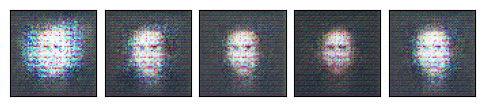

test_batch (Avg. Loss 0.387, Accuracy 43.6): 100%|██████████| 2/2 [00:00<00:00,  8.58it/s]
*** Saved checkpoint checkpoints/optim.pt at epoch 2
test_batch (Avg. Loss 0.793, Accuracy 46.0): 100%|██████████| 2/2 [00:00<00:00,  9.47it/s]
*** Saved checkpoint checkpoints/optim.pt at epoch 3
test_batch (Avg. Loss 0.814, Accuracy 48.9): 100%|██████████| 2/2 [00:00<00:00,  7.92it/s]
*** Saved checkpoint checkpoints/optim.pt at epoch 4
test_batch (Avg. Loss 0.910, Accuracy 51.3): 100%|██████████| 2/2 [00:00<00:00,  8.32it/s]
*** Saved checkpoint checkpoints/optim.pt at epoch 5
test_batch (Avg. Loss 0.779, Accuracy 50.5): 100%|██████████| 2/2 [00:00<00:00,  7.83it/s]
*** Saved checkpoint checkpoints/optim.pt at epoch 6
test_batch (Avg. Loss 0.325, Accuracy 52.9): 100%|██████████| 2/2 [00:00<00:00,  9.51it/s]
*** Saved checkpoint checkpoints/optim.pt at epoch 7
test_batch (Avg. Loss 0.337, Accuracy 52.0): 100%|██████████| 2/2 [00:00<00:00,  9.49it/s]
*** Saved checkpoint checkpoints/optim.pt at 

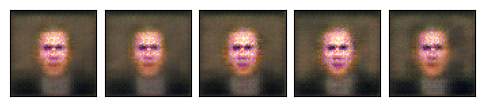

test_batch (Avg. Loss 0.229, Accuracy 54.6): 100%|██████████| 2/2 [00:00<00:00,  7.08it/s]
*** Saved checkpoint checkpoints/optim.pt at epoch 12
test_batch (Avg. Loss 0.199, Accuracy 52.4): 100%|██████████| 2/2 [00:00<00:00,  8.28it/s]
*** Saved checkpoint checkpoints/optim.pt at epoch 13
test_batch (Avg. Loss 0.262, Accuracy 53.0): 100%|██████████| 2/2 [00:00<00:00,  9.40it/s]
*** Saved checkpoint checkpoints/optim.pt at epoch 14
test_batch (Avg. Loss 0.196, Accuracy 53.0): 100%|██████████| 2/2 [00:00<00:00,  9.40it/s]
*** Saved checkpoint checkpoints/optim.pt at epoch 15
test_batch (Avg. Loss 0.168, Accuracy 53.9): 100%|██████████| 2/2 [00:00<00:00,  7.70it/s]
*** Saved checkpoint checkpoints/optim.pt at epoch 16
test_batch (Avg. Loss 0.168, Accuracy 54.0): 100%|██████████| 2/2 [00:00<00:00,  8.35it/s]
*** Saved checkpoint checkpoints/optim.pt at epoch 17
test_batch (Avg. Loss 0.190, Accuracy 52.7): 100%|██████████| 2/2 [00:00<00:00,  9.07it/s]
*** Saved checkpoint checkpoints/optim.

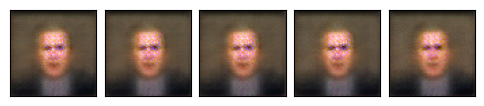

test_batch (Avg. Loss 0.187, Accuracy 53.4): 100%|██████████| 2/2 [00:00<00:00,  8.23it/s]
*** Saved checkpoint checkpoints/optim.pt at epoch 22
test_batch (Avg. Loss 0.148, Accuracy 53.3): 100%|██████████| 2/2 [00:00<00:00,  6.97it/s]
*** Saved checkpoint checkpoints/optim.pt at epoch 23
test_batch (Avg. Loss 0.239, Accuracy 53.7): 100%|██████████| 2/2 [00:00<00:00,  9.63it/s]
*** Saved checkpoint checkpoints/optim.pt at epoch 24
test_batch (Avg. Loss 0.205, Accuracy 55.4): 100%|██████████| 2/2 [00:00<00:00,  8.00it/s]
*** Saved checkpoint checkpoints/optim.pt at epoch 25
test_batch (Avg. Loss 0.147, Accuracy 55.6): 100%|██████████| 2/2 [00:00<00:00,  9.35it/s]
*** Saved checkpoint checkpoints/optim.pt at epoch 26
test_batch (Avg. Loss 0.149, Accuracy 54.0): 100%|██████████| 2/2 [00:00<00:00,  9.50it/s]
*** Saved checkpoint checkpoints/optim.pt at epoch 27
test_batch (Avg. Loss 0.153, Accuracy 54.4): 100%|██████████| 2/2 [00:00<00:00,  8.39it/s]
*** Saved checkpoint checkpoints/optim.

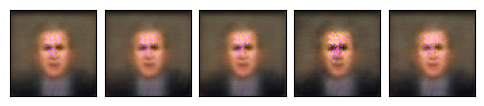

test_batch (Avg. Loss 0.138, Accuracy 53.9): 100%|██████████| 2/2 [00:00<00:00,  9.55it/s]
*** Saved checkpoint checkpoints/optim.pt at epoch 32
test_batch (Avg. Loss 0.116, Accuracy 54.0): 100%|██████████| 2/2 [00:00<00:00,  8.43it/s]
*** Saved checkpoint checkpoints/optim.pt at epoch 33
test_batch (Avg. Loss 0.136, Accuracy 54.4): 100%|██████████| 2/2 [00:00<00:00,  8.74it/s]
*** Saved checkpoint checkpoints/optim.pt at epoch 34
test_batch (Avg. Loss 0.136, Accuracy 55.9): 100%|██████████| 2/2 [00:00<00:00,  9.18it/s]
*** Saved checkpoint checkpoints/optim.pt at epoch 35
test_batch (Avg. Loss 0.120, Accuracy 54.3): 100%|██████████| 2/2 [00:00<00:00,  8.01it/s]
*** Saved checkpoint checkpoints/optim.pt at epoch 36
test_batch (Avg. Loss 0.146, Accuracy 53.7): 100%|██████████| 2/2 [00:00<00:00,  8.65it/s]
*** Saved checkpoint checkpoints/optim.pt at epoch 37
test_batch (Avg. Loss 0.118, Accuracy 54.5): 100%|██████████| 2/2 [00:00<00:00,  8.56it/s]
*** Saved checkpoint checkpoints/optim.

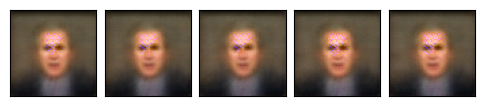

test_batch (Avg. Loss 0.113, Accuracy 55.4): 100%|██████████| 2/2 [00:00<00:00,  9.56it/s]
*** Saved checkpoint checkpoints/optim.pt at epoch 42
test_batch (Avg. Loss 0.147, Accuracy 54.1): 100%|██████████| 2/2 [00:00<00:00,  9.67it/s]
*** Saved checkpoint checkpoints/optim.pt at epoch 43
test_batch (Avg. Loss 0.157, Accuracy 53.8): 100%|██████████| 2/2 [00:00<00:00,  9.45it/s]
*** Saved checkpoint checkpoints/optim.pt at epoch 44
test_batch (Avg. Loss 0.162, Accuracy 53.8): 100%|██████████| 2/2 [00:00<00:00,  9.28it/s]
*** Saved checkpoint checkpoints/optim.pt at epoch 45
test_batch (Avg. Loss 0.182, Accuracy 54.1): 100%|██████████| 2/2 [00:00<00:00,  9.07it/s]
*** Saved checkpoint checkpoints/optim.pt at epoch 46
test_batch (Avg. Loss 0.111, Accuracy 54.2): 100%|██████████| 2/2 [00:00<00:00,  9.36it/s]
*** Saved checkpoint checkpoints/optim.pt at epoch 47
test_batch (Avg. Loss 0.125, Accuracy 55.4): 100%|██████████| 2/2 [00:00<00:00,  9.26it/s]
*** Saved checkpoint checkpoints/optim.

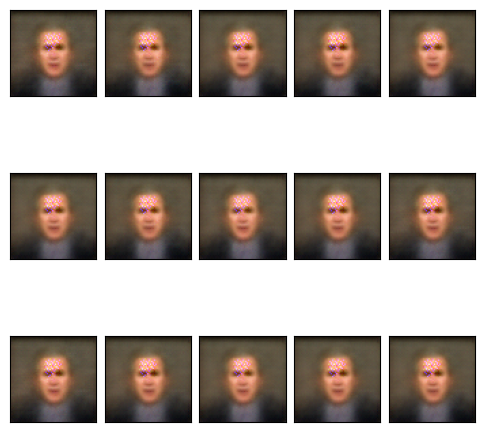

In [25]:
import IPython.display

def post_epoch_fn(epoch, train_result, test_result, verbose):
    # Plot some samples if this is a verbose epoch
    if verbose:
        samples = vae.sample(n=5)
        fig, _ = plot.tensors_as_images(samples, figsize=(6,2))
        IPython.display.display(fig)
        plt.close(fig)

if os.path.isfile(f'{checkpoint_file_final}.pt'):
    print(f'*** Loading final checkpoint file {checkpoint_file_final} instead of training')
    checkpoint_file = checkpoint_file_final
else:
    res = trainer.fit(dl_train, dl_test,
                      num_epochs=200, early_stopping=20, print_every=10,
                      checkpoints=checkpoint_file,
                      post_epoch_fn=post_epoch_fn)
    
# Plot images from best model
saved_state = torch.load(f'{checkpoint_file}.pt', map_location=device)
vae_dp.load_state_dict(saved_state['model_state'])
print('*** Images Generated from best model:')
fig, _ = plot.tensors_as_images(vae_dp.module.sample(n=15), nrows=3, figsize=(6,6))

## Questions
<a id=part2_7></a>

**TODO** Answer the following questions. Write your answers in the appropriate variables in the module `hw3/answers.py`.

In [26]:
from cs236781.answers import display_answer
import hw3.answers

### Question 1

What does the $\sigma^2$ hyperparameter (`x_sigma2` in the code) do? Explain the effect of low and high values.

In [27]:
display_answer(hw3.answers.part2_q1)


the role of $\sigma^2$ can be understood from the two terms it appears in. 
<br>
first, the likelihood equation: $p _{\bb{\beta}}(\bb{X} | \bb{Z}=\bb{z}) = \mathcal{N}( \Psi _{\bb{\beta}}(\bb{z}) , \sigma^2 \bb{I} )$ from this we can see that $\sigma^2$ control the variance of the likelihood distribution around the decoder output. this correspond to variance in the generated instances given a latent representation. low $\sigma^2$ leads to generated instances be more concentrated and tightly clustered around the point calculated by the decoder. this results in high fidelity to the training data (overfitting). from the other hand, it might not be able to generalize instances (different pose for example) well. high $\sigma^2$ leads to the opposite - more diversity in instances but can also introduce more randomness and noise into the generated instances, potentially deviating from the training data.
<br>
the second term that includes $\sigma^2$ is the loss. it appears in the denominator of the reconstruction error and serve as a parameter that balances the two terms of the loss. high $\sigma^2$ gives more weight to the KL term which has the role of regularisation term - increases the variance and diversity. low $\sigma$ gives more weight to the reconstruction term which fit the instances directly to the training data.
<br> we see that the role of $\sigma^2$ coincides - control the amount of regularization and variance of sampled instances 




### Question 2

1. Explain the purpose of both parts of the VAE loss term - reconstruction loss and KL divergence loss.
2. How is the latent-space distribution affected by the KL loss term?
3. What's the benefit of this effect?

In [28]:
display_answer(hw3.answers.part2_q2)


1. The reconstruction loss measures how well the model is able to reconstruct the input data from the latent space. It encourages the decoder network to generate outputs that are similar to the original input data.
<br>
The regularization loss encourages the encoder to learn a regularized latent space. Its goal is to ensure that the latent space follows a specific probability distribution (normal in our case), and in doing so it ensures diveresity, continuity and meaningfulness of the instances. 
<br>
2. the KL term regularize the latent space by enforcing it to be of specific distribution. Without a well defined regularisation term, the model can learn, in order to minimise its reconstruction error, to “ignore” the fact that distributions are returned and behave almost like classic autoencoders (leading to overfitting). To do so, the encoder can either return distributions with tiny variances (that would tend to be punctual distributions) or return distributions with very different means. In order to avoid these effects we have to regularise both the covariance matrix and the mean of the distributions returned by the encoder, which done by the KL loss term. this would increase the continuity (close points in the latent space become close decoded samples) and the completenes (points sampled from the latent space are meaninfull) of the latent space.
<br>
the benefits are:
<br>
Regularization: By aligning the approximate posterior distribution with the prior distribution, the KL loss acts as a regularization term. It helps prevent overfitting and increase the variability of the model.
well behaved and Controllable latent space: as mentioned above, the KL term induce continuity and smoothness of the latent space. since we can describe the latent space by two parameters (std and mean) it is also controllable.    




### Question 3

In the formulation of the VAE loss, why do we start by maximizing the evidence 
distribution, $p(\bb{X})$?

In [29]:
display_answer(hw3.answers.part2_q3)


**Your answer:**





### Question 4

In the VAE encoder, why do we model the **log** of the 
latent-space variance corresponding to an input, $\bb{\sigma}^2_{\bb{\alpha}}$,
instead of directly modelling this variance?

In [30]:
display_answer(hw3.answers.part2_q4)


in a VAE we sample $z$ from a normal distribution. modeling the log of its variance instead of the actual variance has some benefits: 
<br>
1.it is more numericaly stable to work in log space, espacially when the variance is small.
<br>
2. its aligned with the assumption that the distribution is normal with diagonal covariance matrix -  for multivariate Gaussian with a diagonal covariance matrix, the matrix is exponentiated elementwise so by taking the log of the matrix, we get the actual variance elements. this is also the motivation to take $/log(sigma^2)$ as explained in the VAE paper.  



